# Analyzing County Vote Shifts from 2012 to 2016

This project builds upon a previous project of mine, <a href="https://nbviewer.jupyter.org/github/MWdataanalytics/Data_Analytics_Portfolio/blob/master/Notebooks/Exploring_Election_Data.ipynb"><i>Exploring Presidential Election Data</i></a>, to analyze the 2012-2016 election vote shifts for every US county. My workflow is structured as follows:
1. Web scraping 2012 and 2016 county level election data votes using BeautifulSoup
2. Data cleaning and merging 2012 and 2016 election data  using pandas
3. Geographically mapping county vote shifts using plotly
4. Factoring in county population density data
5. Plotting county vote shifts vs. population density using matplotlib and seaborn
6. Making final conclusions

In [1]:
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import plotly.figure_factory as ff

%matplotlib inline

## Web Scraping

We'll start by inspecting the code behind the New York Times' webpages that display county level vote data for the 2012 and 2016 presidential election. We'll write scripts to pull this election data into a clean, organized dataframe.

First we'll define a few functions that can be used for both scripts.

In [2]:
#Define function that gets script from a website
def webpage_script(url, string, kwd_idx, script_class=None, script_kwd=None):
    webpage_url = url
    response = requests.get(url)
    content= response.content
    soup = BeautifulSoup(content, 'html.parser')
    get_data = soup.find_all(string,{script_class:script_kwd})[kwd_idx]
    data = get_data.text
    return data

#Define function for this specific script that slices string values
def get_script_value(input_string, start_identifier, end_identifier=','):
    val_start = input_string.find(start_identifier) + len(start_identifier)
    val_end = input_string.find(end_identifier, val_start)
    value = input_string[val_start:val_end]
    val_trimmed = value.strip()
    return value

### Web Scraping 2016 Election Results by County

In [3]:
url_2016 = "https://www.nytimes.com/elections/results/president"

#Get 2016 election result data for each county in the US
raw_data_2016 = webpage_script(url_2016, "script", 1)
state_data_2016 = raw_data_2016.split("state_id")
cleaned_state_data_2016 = state_data_2016[1:len(state_data_2016)]

#Iterate over each state to get county vote numbers
data_list = []
for item in cleaned_state_data_2016: 
    clean_string = item.replace('"','')
    state_name = get_script_value(clean_string, "state_slug:").replace("-"," ").title()
    county_list = clean_string.split("fips")
    for county in county_list:
        fips_search = county[1:6]
        if re.match("[0-9]{5}", fips_search):
            fips = fips_search
        else:
            continue
        county_name = get_script_value(county, "name:").title() 
        clinton_votes = int(get_script_value(county, "clintonh:"))
        trump_votes = int(get_script_value(county, "trumpd:"))
        total_votes = int(get_script_value(county, "votes:"))
        data_list.append([fips, state_name, county_name, clinton_votes, trump_votes, total_votes])

#Convert list of lists to a pandas dataframe
df_2016 = pd.DataFrame(data_list, columns=['fips_code','State','County','2016_D_votes','2016_R_votes','2016_total_votes'])

df_2016.head() #preview dataframe

,fips_code,State,County,2016_D_votes,2016_R_votes,2016_total_votes
0,02000,Alaska,Alaska,116454,163387,309407
1,01087,Alabama,Macon,7566,1431,9140
2,01055,Alabama,Etowah,10442,32353,44164
3,01007,Alabama,Bibb,1874,6738,8819
4,01127,Alabama,Walker,4497,24266,29472


In [4]:
df_2016.shape #check how many records we have

(3113, 6)

### Web Scraping 2012 Election Results by County

Unfortunately, the back-end code for the 2012 results  webpage is structured completely differently than the 2016 one. A new script is needed to pull this data.

In [5]:
url_2012 = "https://www.nytimes.com/elections/2012/results/president.html"

#Get 2012 election results for each county in the US
raw_data_2012 = webpage_script(url_2012, "script", 6, script_class='type', script_kwd='text/javascript')
state_data_2012 = raw_data_2012.split("county_votes")
cleaned_state_data = state_data_2012[1:len(state_data_2012)]

data_list = []
for item in cleaned_state_data:
    #Only candidate vote totals and fips are needed, as we can join state and county names on fips codes
    clean_string = item.replace('"','')
    clean_string = clean_string.replace('[','') 
    #Get code identifier for each candidate
    obama_code_string = get_script_value(clean_string, "cand_shortname:Obama", 
                                         end_identifier="cand_longname:Barack Obama")
    obama_code = get_script_value(obama_code_string, "votes_field:", ",") 
    romney_code_string = get_script_value(clean_string, "cand_shortname:Romney", 
                                          end_identifier="cand_longname:Mitt Romney")
    romney_code = get_script_value(romney_code_string, "votes_field:")  
    #Get string values of interest in script
    fips_codes = get_script_value(clean_string, "location_fips:", end_identifier="]")
    obama_votes = get_script_value(clean_string, obama_code + ":", end_identifier="]")
    romney_votes = get_script_value(clean_string, romney_code + ":", end_identifier="]")
    total_votes = get_script_value(clean_string, "total_votes:", end_identifier="]")
    #Must convert these strings to lists, as data here is not broken out but rather provided in lists
    fips_codes_list = fips_codes.split(",")
    obama_votes_list = obama_votes.split(",")
    romney_votes_list = romney_votes.split(",")
    total_votes_list = total_votes.split(",")
    #Convert seperate lists to an ordered list of lists
    for i in range(0, len(fips_codes_list)):
        data_list.append([fips_codes_list[i], int(obama_votes_list[i]), int(romney_votes_list[i]), int(total_votes_list[i])])

#Convert list of lists to a pandas dataframe
df_2012 = pd.DataFrame(data_list, columns=['fips_code','2012_D_votes','2012_R_votes','2012_total_votes'])

df_2012.head() #preview dataframe

,fips_code,2012_D_votes,2012_R_votes,2012_total_votes
0,56001,7445,7851,16052
1,56003,868,4269,5262
2,56005,2163,14952,17477
3,56007,2109,4152,6461
4,56009,1089,5043,6287


In [6]:
df_2012.shape #check how many records we have

(3114, 4)

## Data Cleaning and Merging

Now that we have two dataframes for both elections, we'll have to merge and clean them accordingly to calculate vote shifts.

In [7]:
county_df = df_2016.merge(df_2012, on='fips_code', how='outer')
county_df.shape #check for number of rows 

(3115, 9)

In [8]:
#Check for any null values and investigate
county_df[county_df['2016_total_votes'].isnull()|county_df['2012_total_votes'].isnull()]

,fips_code,State,County,2016_D_votes,2016_R_votes,2016_total_votes,2012_D_votes,2012_R_votes,2012_total_votes
2383,46102,South Dakota,Oglala Lakota,2510.0,241.0,2905.0,NaN,NaN,NaN
3113,51515,NaN,NaN,NaN,NaN,NaN,1225.0,1527.0,2798.0
3114,46113,NaN,NaN,NaN,NaN,NaN,2922.0,188.0,3130.0


There are 3 fips codes with null values. After googling these fips codes, I discovered the following:
* The independent city of Bedford Virginia was removed (FIPS 51515) and included in Bedford County, Virginia (FIPS 51019) sometime between the 2012 and 2016 election.
* Shannon County, SD (FIPS 46113) was renamed Oglala Lakota County and assigned a new FIPS code (46102) on May 1, 2015.

We'll focus on cleaning the 2012 county data so that it matches up with the 2016 data and merge again.

In [9]:
df_2012[df_2012['fips_code']=='46113'] #view original index of Oglala Lakota

,fips_code,2012_D_votes,2012_R_votes,2012_total_votes
2986,46113,2922,188,3130


In [10]:
df_2012.iloc[2986,0] = '46102' #adjust Oglala Lakota county fips code

df_2012[df_2012['fips_code'].isin(['51515','51019'])] #view index location of Bedford city

,fips_code,2012_D_votes,2012_R_votes,2012_total_votes
1566,51019,10925,29281,40750
1567,51515,1225,1527,2798


In [11]:
#Combine votes in two Bedford rows
df_2012.iloc[1567,:] = df_2012.iloc[1566,:] + df_2012.iloc[1567,:]
df_2012.iloc[1567,0] = '51019' #replace fips_code with correct value
df_2012.drop([1566], inplace=True) #drop Bedford city row
df_2012.reset_index(drop=True, inplace=True)
df_2012.shape #check to see there are 3113 rows 

(3113, 4)

In [12]:
county_data = df_2016.merge(df_2012, on='fips_code', how='outer')
county_data.shape #make sure there are now 3113 rows

(3113, 9)

In [13]:
county_data.head() #preview dataframe

,fips_code,State,County,2016_D_votes,2016_R_votes,2016_total_votes,2012_D_votes,2012_R_votes,2012_total_votes
0,02000,Alaska,Alaska,116454,163387,309407,102138,136848,247483
1,01087,Alabama,Macon,7566,1431,9140,9045,1322,10385
2,01055,Alabama,Etowah,10442,32353,44164,12792,29102,42490
3,01007,Alabama,Bibb,1874,6738,8819,2200,6131,8391
4,01127,Alabama,Walker,4497,24266,29472,6551,21633,28497


### Calculating New Fields

We'll take the data we have and perform some operations to add additional columns that might be of interest in later analysis.

In [14]:
#Add 2016 calculated fields
county_data['2016_R_pct'] = round(100*(county_data['2016_R_votes']/county_data['2016_total_votes']),2)
county_data['2016_D_pct'] = round(100*(county_data['2016_D_votes']/county_data['2016_total_votes']),2)
county_data['2016_R_margin'] = county_data['2016_R_pct'] - county_data['2016_D_pct']

#Add 2012 calculated fields
county_data['2012_R_pct'] = round(100*(county_data['2012_R_votes']/county_data['2012_total_votes']),2)
county_data['2012_D_pct'] = round(100*(county_data['2012_D_votes']/county_data['2012_total_votes']),2)
county_data['2012_R_margin'] = county_data['2012_R_pct'] - county_data['2012_D_pct']

#Calculate vote increase and shift
county_data['vote_inc_pct'] = round(100*(county_data['2016_total_votes'] - county_data['2012_total_votes'])/county_data['2012_total_votes'],2)
county_data['R_margin_shift'] = county_data['2016_R_margin'] - county_data['2012_R_margin']

county_data.head()

,fips_code,State,County,2016_D_votes,2016_R_votes,2016_total_votes,2012_D_votes,2012_R_votes,2012_total_votes,2016_R_pct,2016_D_pct,2016_R_margin,2012_R_pct,2012_D_pct,2012_R_margin,vote_inc_pct,R_margin_shift
0,02000,Alaska,Alaska,116454,163387,309407,102138,136848,247483,52.81,37.64,15.17,55.30,41.27,14.03,25.02,1.14
1,01087,Alabama,Macon,7566,1431,9140,9045,1322,10385,15.66,82.78,-67.12,12.73,87.10,-74.37,-11.99,7.25
2,01055,Alabama,Etowah,10442,32353,44164,12792,29102,42490,73.26,23.64,49.62,68.49,30.11,38.38,3.94,11.24
3,01007,Alabama,Bibb,1874,6738,8819,2200,6131,8391,76.40,21.25,55.15,73.07,26.22,46.85,5.10,8.30
4,01127,Alabama,Walker,4497,24266,29472,6551,21633,28497,82.34,15.26,67.08,75.91,22.99,52.92,3.42,14.16


We'll focus mainly on vote shifts going forward. Let's trim this dataframe to only keep columns that are essential to our analysis.

In [15]:
county_shifts = county_data[['fips_code','State','County','2012_R_margin','2016_R_margin','vote_inc_pct'
                             ,'R_margin_shift']]
county_shifts = county_shifts[1:] #remove Alaska as we don't have individual county data (including fips) 

county_shifts.head()

,fips_code,State,County,2012_R_margin,2016_R_margin,vote_inc_pct,R_margin_shift
1,01087,Alabama,Macon,-74.37,-67.12,-11.99,7.25
2,01055,Alabama,Etowah,38.38,49.62,3.94,11.24
3,01007,Alabama,Bibb,46.85,55.15,5.10,8.30
4,01127,Alabama,Walker,52.92,67.08,3.42,14.16
5,01119,Alabama,Sumter,-54.59,-49.37,-8.74,5.22


## Mapping County Data

We'll use plotly to map county data in order to answer the following questions:
* Which counties (and regions) shifted the most to the right in 2016?
* Which counties (and regions) shifted the most to the left in 2016?
* Which counties voted for Obama in 2012 and Trump in 2016?
* Which counties voted for Romney in 2012 and Clinton in 2016?

In [16]:
#Define shared map layout
def set_map_layout(df, title, legend_title, colorscale, endpts, shifts='R_margin_shift'):
    fips = df['fips_code']
    values = round(df[shifts], 1)
    fig = ff.create_choropleth(
        fips=fips, values=values,
        binning_endpoints=endpts,
        colorscale=colorscale,
        show_state_data=True,
        round_legend_values=True,
        show_hover=True,
        asp=2.8, title=title,
        legend_title=legend_title
    )
    return fig

### Mapping All County Shifts

In [17]:
r_shift_colorscale = ["#002db3","#0040ff","#4d79ff","#99b3ff","#e6ecff","#ffe6e6",
                      "#ff9999","#ff4d4d","#ff0000","#b30000","#800000","#4d0000"]
r_shift_title = 'Shift in Republican Vote Margin 2012-2016'
r_shift_legend = 'Republican vote margin shift'
r_shift_endpts = list(np.arange(-20, 35, 5))

r_shift_fig = set_map_layout(county_shifts, r_shift_title, r_shift_legend, r_shift_colorscale, r_shift_endpts)

py.iplot(r_shift_fig, filename='r_shifts_2016', sharing='public')

The draw time for this plot will be slow for clients without much RAM.


/anaconda3/lib/python3.6/site-packages/plotly/api/v1/clientresp.py:40: UserWarning:

Estimated Draw Time Slow



Analysis:
* The most pronounced shifts in Republican vote margin came from the Midwest and northern New England/New York. 
* A few pocketed regions swung drastically to the right: Appalachian Ohio, Ozark Missouri, eastern Michigan, and northern New York, among others.
* Almost all of Utah swung left because of the popularity of Evan McMullin and the unpopularity of Trump among Mormons, as explained in my previous project, <a href="https://nbviewer.jupyter.org/github/MWdataanalytics/Data_Analytics_Portfolio/blob/master/Notebooks/Exploring_Election_Data.ipynb"><i>Exploring Presidential Election Data</i></a>. 
* Almost all of California swung left, presumbly due to the growing young Hispanic population in the state, which could also explain the Democratic swings in southern Arizona. 
* A handful of metro area swung to the left in 2016, including Boston, DC, Raleigh-Durham, Atlanta, Dallas, Houston, Austin, San Diego, LA, San Francisco, and Salt Lake City. 

By visualizing shifts by county and region, we can uncover the growing rural-urban divide in American politics. 

Now we'll only map vote shifts in counties that voted for Obama in 2012 and Trump in 2016, which made a huge impact in the election result. 

In [18]:
obama_trump_counties = county_shifts[(county_shifts['2012_R_margin'] < 0.0) & (county_shifts['2016_R_margin'] > 0.0)]
obama_trump_counties.head()

,fips_code,State,County,2012_R_margin,2016_R_margin,vote_inc_pct,R_margin_shift
35,01005,Alabama,Barbour,-2.91,5.57,-8.64,8.48
54,01035,Alabama,Conecuh,-1.66,5.17,-6.10,6.83
125,05147,Arkansas,Woodruff,-4.21,8.90,-4.25,13.11
221,08015,Colorado,Chaffee,-0.18,4.47,10.11,4.65
250,08101,Colorado,Pueblo,-13.10,0.49,7.28,13.59


### Mapping Shifts in Obama-Trump Counties

In [19]:
obama_trump_colorscale = ["#e6ecff","#ffe6e6","#ff9999","#ff4d4d","#ff0000","#b30000",
                          "#800000","#4d0000"]
obama_trump_title = 'Obama-Trump Counties'
obama_trump_legend = 'Republican vote margin shift'
obama_trump_endpts = list(np.arange(0, 30, 5))

obama_trump_fig = set_map_layout(obama_trump_counties, obama_trump_title, obama_trump_legend, 
                                 obama_trump_colorscale, obama_trump_endpts)

py.iplot(obama_trump_fig, filename='obama_trump_counties', sharing='public')

Analysis:
* Though several counties across the country voted for Obama in 2012 and Trump in 2016, the regions with the highest concentration of Obama-Trump counties (and largest shifts) appear to be in the Upper Mississippi River Valley and northern Maine, New Hampshire, and Vermont. These are white, rural regions that voted Democrat, dating back to the 90's. This could suggest that 2016 finally became the year in which demographic divides transcended traditional regional divides and highlights the widening rural-urban divide.

Let's now take a look at the counties that voted for Romney in 2012 and Clinton in 2016. 

In [20]:
romney_clinton_counties = county_shifts[(county_shifts['2012_R_margin'] > 0.0) & (county_shifts['2016_R_margin'] < 0.0)]
romney_clinton_counties['D_margin_shift'] = -(romney_clinton_counties['R_margin_shift'])
romney_clinton_counties.head()

,fips_code,State,County,2012_R_margin,2016_R_margin,vote_inc_pct,R_margin_shift,D_margin_shift
174,06057,California,Nevada,4.65,-4.90,77.99,-9.55,9.55
176,06059,California,Orange,8.28,-8.59,17.25,-16.87,16.87
183,06019,California,Fresno,2.93,-6.03,59.26,-8.96,8.96
187,06065,California,Riverside,0.42,-5.38,27.41,-5.80,5.80
391,13067,Georgia,Cobb,12.60,-2.16,8.11,-14.76,14.76


### Mapping Shifts in Romney-Clinton Counties

In [21]:
romney_clinton_colorscale = ["#ffe6e6","#e6ecff","#99b3ff","#4d79ff","#0040ff","#002db3"]
romney_clinton_title = 'Romney-Clinton Counties'
romney_clinton_legend= 'Democratic vote margin shift'
romney_clinton_endpts = list(np.arange(0, 25, 5))

romney_clinton_fig = set_map_layout(romney_clinton_counties, romney_clinton_title, romney_clinton_legend, 
                                    romney_clinton_colorscale, romney_clinton_endpts, shifts='D_margin_shift')

py.iplot(romney_clinton_fig, filename='romney_clinton_counties', sharing='public')

Analysis:
* The Romney-Clinton counties with the highest Democratic shifts appear to be in metroplitan areas, including Atlanta, Houston, Salt Lake City, and LA. 
* Very few rural counties voted for Romney, then Clinton; and even the ones that did only showed only a small vote shift. 

## Incorporating Population Density

One way to analyze the rural-urban divide in the 2016 election is to factor in county population density data. My hypothesis is that the counties that swung the most Republican are among the least densely populated counties and the counties that swung the most Democratic are among the most densely populated counties. I'll be using <a href="https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?src=bkmk">2010 census data</a> to clean and merge county population density into our existing dataframe. 

In [22]:
county_info_df = pd.read_csv('~/Documents/Data Projects/County Vote Shifts/Data Sources/County_Pop_Density.csv', encoding = "ISO-8859-1")
county_info_df.head()

,GEO.id,GEO.id2,GEO.display-label,GCT_STUB.target-geo-id,GCT_STUB.target-geo-id2,GCT_STUB.display-label,GCT_STUB.display-label.1,HD01,HD02,SUBHD0301,SUBHD0302,SUBHD0303,SUBHD0401,SUBHD0402
0,0100000US,NaN,United States,0100000US,NaN,United States,United States,308745538,131704730,3796742.23,264836.79,3531905.43,87.4,37.3
1,0100000US,NaN,United States,0400000US01,1.0,United States - Alabama,Alabama,4779736,2171853,52420.07,1774.74,50645.33,94.4,42.9
2,0100000US,NaN,United States,0500000US01001,1001.0,United States - Alabama - Autauga County,Autauga County,54571,22135,604.39,9.95,594.44,91.8,37.2
3,0100000US,NaN,United States,0500000US01003,1003.0,United States - Alabama - Baldwin County,Baldwin County,182265,104061,2027.31,437.53,1589.78,114.6,65.5
4,0100000US,NaN,United States,0500000US01005,1005.0,United States - Alabama - Barbour County,Barbour County,27457,11829,904.52,19.64,884.88,31.0,13.4


In [23]:
#Clean table and only keep fips and population density 
county_density_df = county_info_df[['GCT_STUB.target-geo-id2','SUBHD0401']]
county_density_df.columns = ['fips_code','pop_density']
county_density_df['fips_code'] = county_density_df['fips_code'].fillna(0.0)
county_density_df['fips_code'] = county_density_df['fips_code'].astype(int).astype(str)
county_density_df['fips_code'] = county_density_df['fips_code'].str.zfill(5)

county_density_df.head()

,fips_code,pop_density
0,00000,87.4
1,00001,94.4
2,01001,91.8
3,01003,114.6
4,01005,31.0


In [24]:
#Merge with vote data
county_votes_density = county_shifts.merge(county_density_df, how='left', on='fips_code')
county_votes_density[county_votes_density.isnull().any(axis=1)] #check for null values

,fips_code,State,County,2012_R_margin,2016_R_margin,vote_inc_pct,R_margin_shift,pop_density
2382,46102,South Dakota,Oglala Lakota,-87.34,-78.1,-7.19,9.24,NaN


Since we are using 2010 census data, we'll have to change Oglala Lakota's fips code back to its old one (46113) and re-merge. 

In [25]:
fixed_county_shifts = county_shifts.copy()
fixed_county_shifts.iloc[2382,0] = '46113'
county_votes_density = fixed_county_shifts.merge(county_density_df, how='left', on='fips_code')

county_votes_density[county_votes_density.isnull().any(axis=1)]  #check again for null values

,fips_code,State,County,2012_R_margin,2016_R_margin,vote_inc_pct,R_margin_shift,pop_density


We'll eventually use matplotlib and seaborn see how population density corresponds to vote shift and analyze the increasing rural-urban divide in voting patterns.

First, let's analyze the counties that shifted the most Democratic and Republican. 

In [26]:
top_10_democratic = county_votes_density.sort_values('R_margin_shift',ascending=True)
top_10_democratic.head(10)

,fips_code,State,County,2012_R_margin,2016_R_margin,vote_inc_pct,R_margin_shift,pop_density
2771,49049,Utah,Utah,78.47,36.17,26.27,-42.30,257.8
2749,49005,Utah,Cache,68.42,26.92,25.93,-41.50,96.7
652,16065,Idaho,Madison,87.52,49.33,8.85,-38.19,80.0
2752,49011,Utah,Davis,61.84,23.84,24.63,-38.00,1025.8
2761,49029,Utah,Morgan,80.64,50.29,18.81,-30.35,15.5
2764,49035,Utah,Salt Lake,19.33,-8.92,24.02,-28.25,1387.1
2748,49003,Utah,Box Elder,78.16,50.05,9.87,-28.11,8.7
2772,49051,Utah,Wasatch,52.20,24.88,34.66,-27.32,20.0
2775,49057,Utah,Weber,46.04,19.89,26.21,-26.15,401.4
2766,49039,Utah,Sanpete,78.12,54.77,16.39,-23.35,17.5


9/10 of the top margin democratic margin shifts came from Utah. However, this is a bit misleading since we are only factoring in margin and independent candidate Evan McMullin, who identifies as Republican, received a large of votes from Republicans in Utah. We'll remove Utah counties going forward, as this anomaly was specific to Utah. 

In [27]:
new_county_votes_density = county_votes_density[county_votes_density['State'] != 'Utah']

top_10_republican = new_county_votes_density.sort_values('R_margin_shift',ascending=False)
top_10_republican.head(10)

,fips_code,State,County,2012_R_margin,2016_R_margin,vote_inc_pct,R_margin_shift,pop_density
994,21063,Kentucky,Elliott,-2.50,44.13,19.01,46.63,33.5
1393,29045,Missouri,Clark,10.29,52.30,2.82,42.01,14.1
565,19089,Iowa,Howard,-21.06,20.49,-1.43,41.55,20.2
699,17071,Illinois,Henderson,-12.32,28.43,-1.26,40.75,19.3
2068,39111,Ohio,Monroe,7.91,46.78,1.63,38.87,32.1
1417,29093,Missouri,Iron,14.47,52.47,5.90,38.00,19.3
2094,39163,Ohio,Vinton,7.77,45.70,3.51,37.93,32.6
1460,29179,Missouri,Reynolds,24.15,61.43,-4.94,37.28,8.3
3040,54013,West Virginia,Calhoun,22.58,59.85,22.30,37.27,27.3
1480,29221,Missouri,Washington,18.64,55.18,7.73,36.54,33.2


In [28]:
r_shifts = new_county_votes_density[new_county_votes_density['R_margin_shift'] > 0]
d_shifts = new_county_votes_density[new_county_votes_density['R_margin_shift'] < 0]

### Using a Scatterplot to Analyze the Population Density Factor
Let's now use a matplotlib scatterplot to visualize how population density impacted vote margin shifts.

Text(0.5,1,'Population Density vs. 2012-2016 Vote Margin Shift')

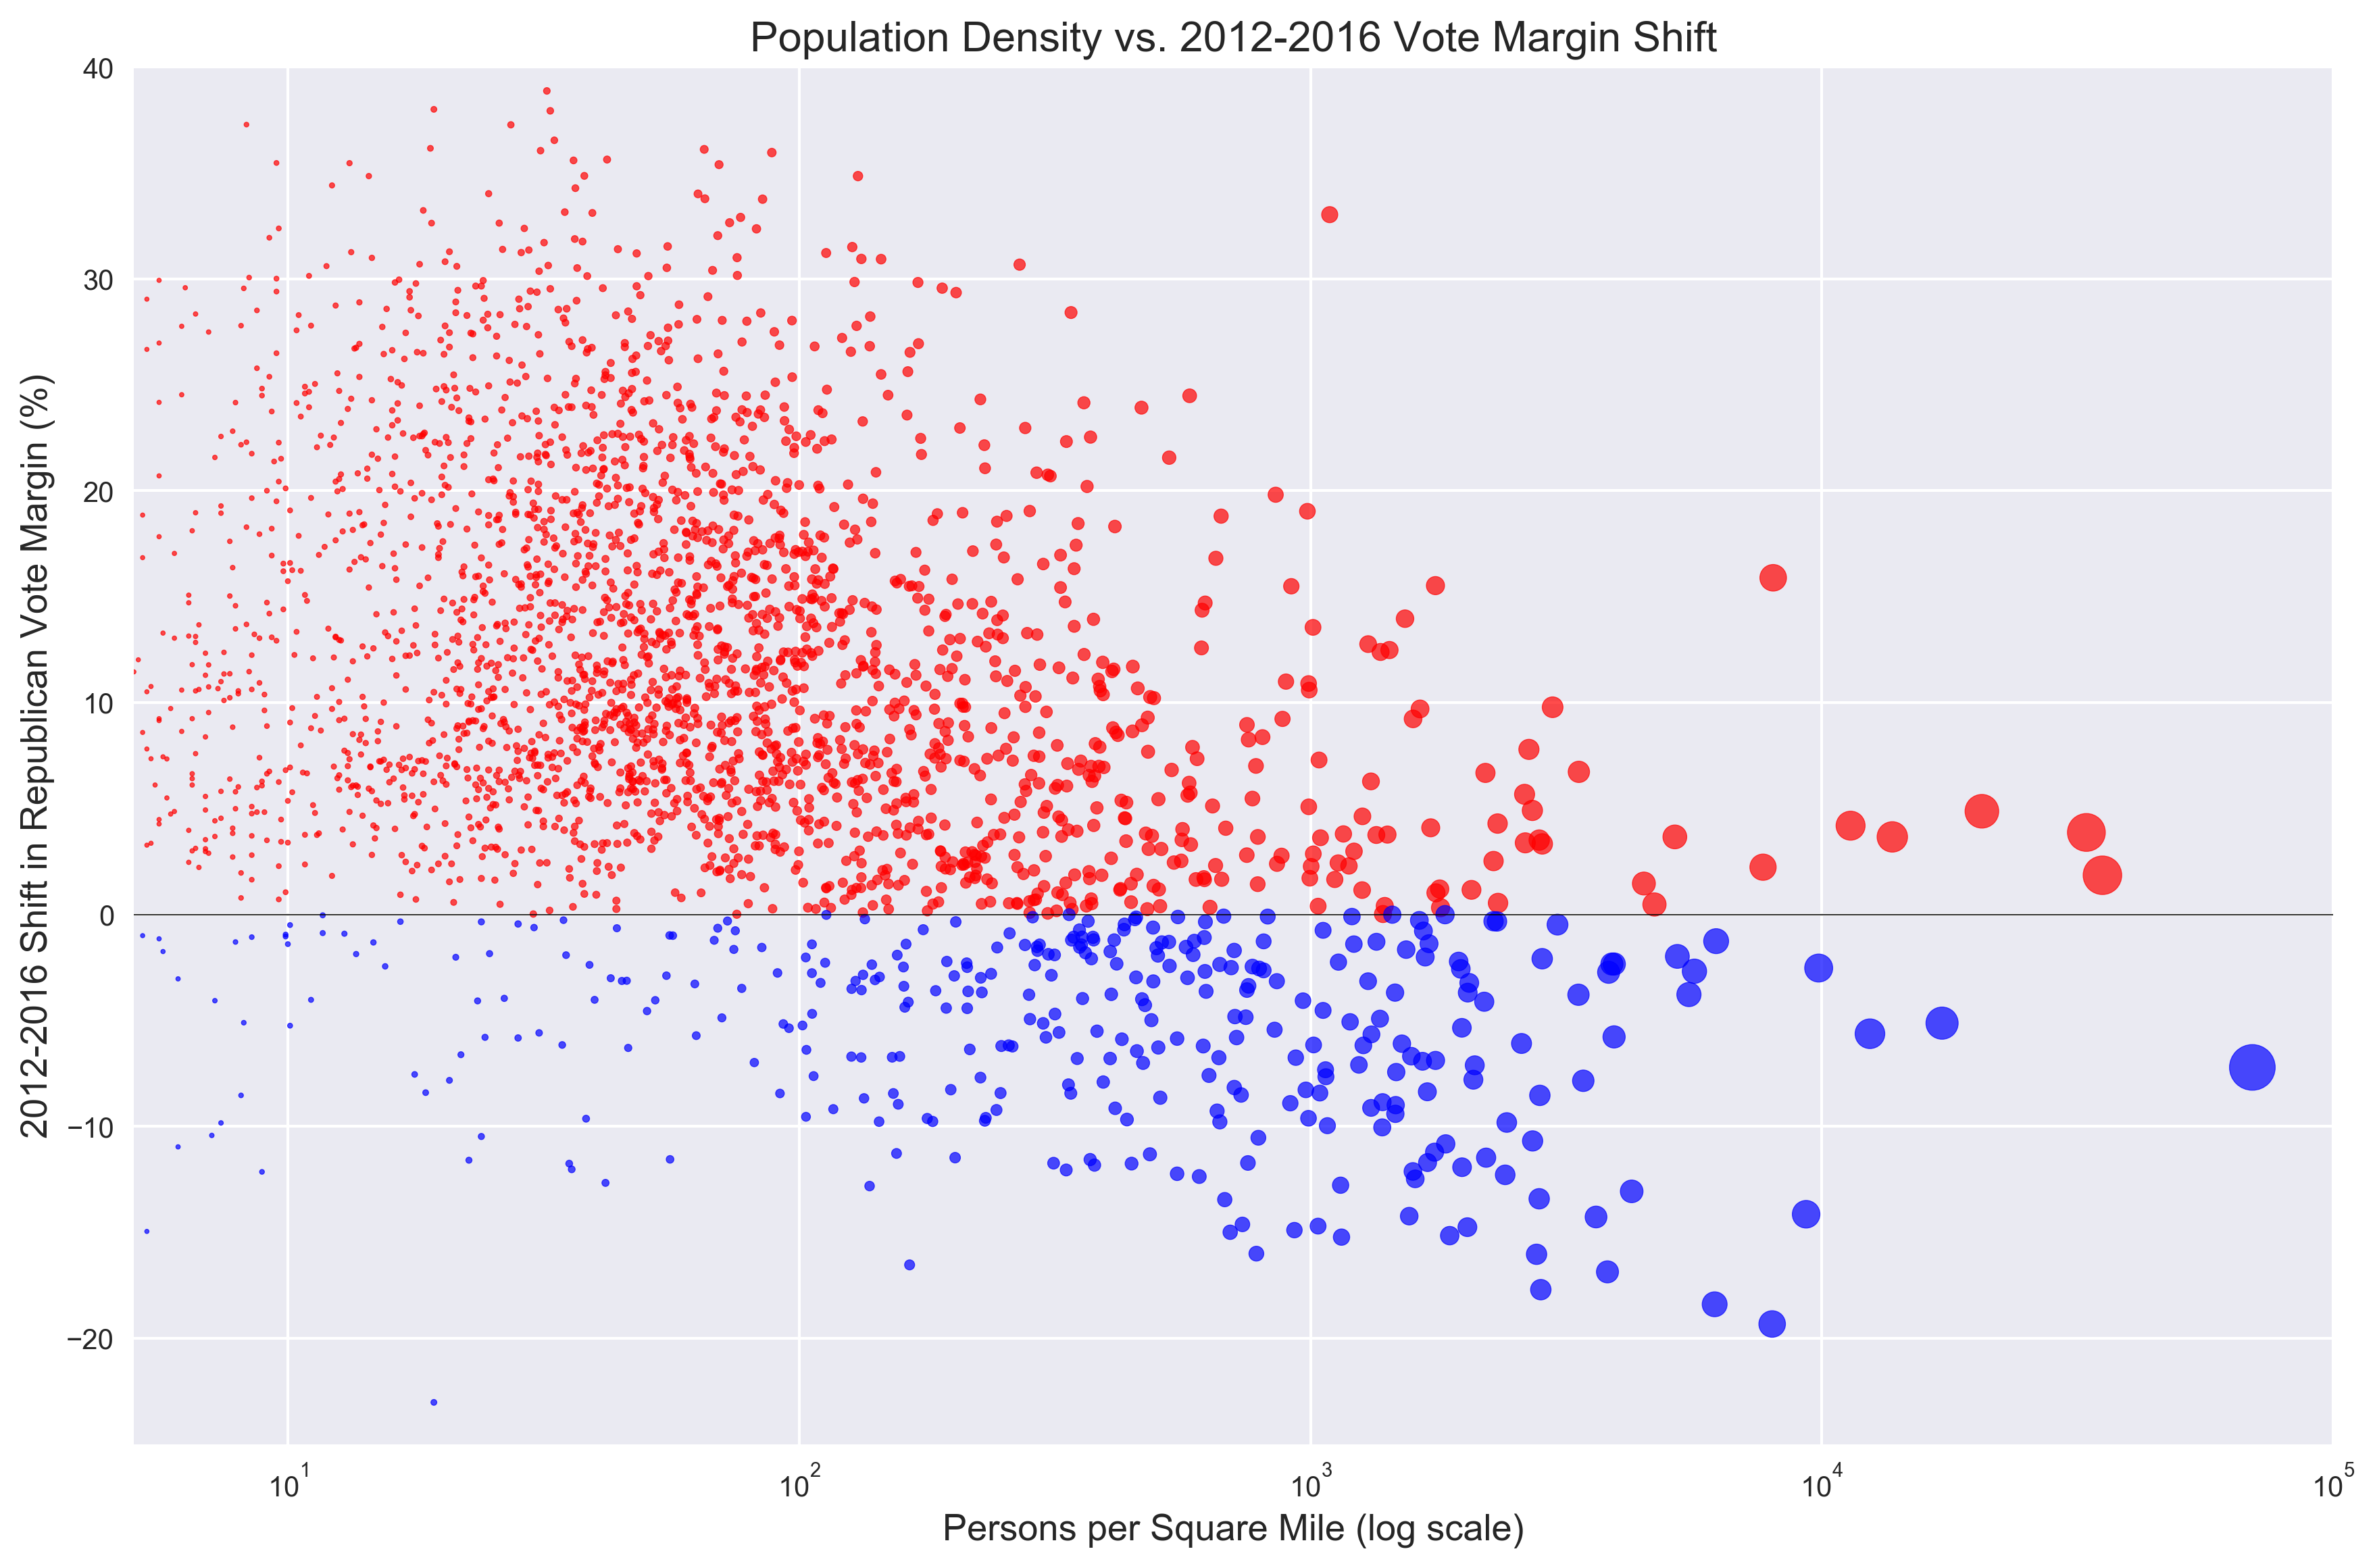

In [29]:
#Plot shifts vs. population density
plt.style.use('seaborn')
fig = plt.figure(figsize=(14,9),dpi=300)
ax = plt.gca()
ax.scatter(r_shifts['pop_density'], r_shifts['R_margin_shift'], s=np.sqrt(r_shifts['pop_density']), c='r',alpha=0.7)
ax.scatter(d_shifts['pop_density'], d_shifts['R_margin_shift'], s=np.sqrt(d_shifts['pop_density']), c='b',alpha=0.7)
ax.set_xscale('log')
ax.set_ylim(-25,40)
ax.set_xlim(5,100000)
ax.axhline(y=0, c='k', alpha=0.8, lw=0.5)
ax.set_xlabel('Persons per Square Mile (log scale)',fontsize=13)
ax.set_ylabel('2012-2016 Shift in Republican Vote Margin (%)',fontsize=13)
ax.set_title('Population Density vs. 2012-2016 Vote Margin Shift',fontsize=15)

<b>Note</b>: some of the least densely populated counties are cropped out in the interest of zooming the visual.

We can see a pretty clear pattern here. The less densely populated a county, the more likely it shifted Republican from 2012 to 2016 and vice versa. This chart illustrates how much more pronounced the rural-urban divide became in the 2016 election. 

It will be interesting to see median population density for counties with Republican shifts vs. counties with Democratic shifts. 

In [30]:
r_shifts_median = np.median(r_shifts['pop_density'])
d_shifts_median = np.median(d_shifts['pop_density'])

print('Median density of R shifts: ', r_shifts_median)
print('Median density of D shifts: ', d_shifts_median)

Median density of R shifts:  41.1
Median density of D shifts:  334.5


This is a pretty stark contrast. Let's take these comparisons a step further and show box plots for Republican shift densities and Democratic shift densities so that we can compare the interquartile range.

### Using a Boxplot to Analyze Population Density Factor

We'll use a seaborn boxplot to visualize how population densities differed between the two seperate shift categories.

In [31]:
#Prepare data for boxplot
r_shifts_labeled = r_shifts.copy()
r_shifts_labeled['Shift'] = 'Republican'

d_shifts_labeled = d_shifts.copy()
d_shifts_labeled['Shift'] = 'Democratic'

new_shifts = pd.concat([r_shifts_labeled, d_shifts_labeled])

Text(0.5,1,'Comparing Population Densities between County Vote Shifts')

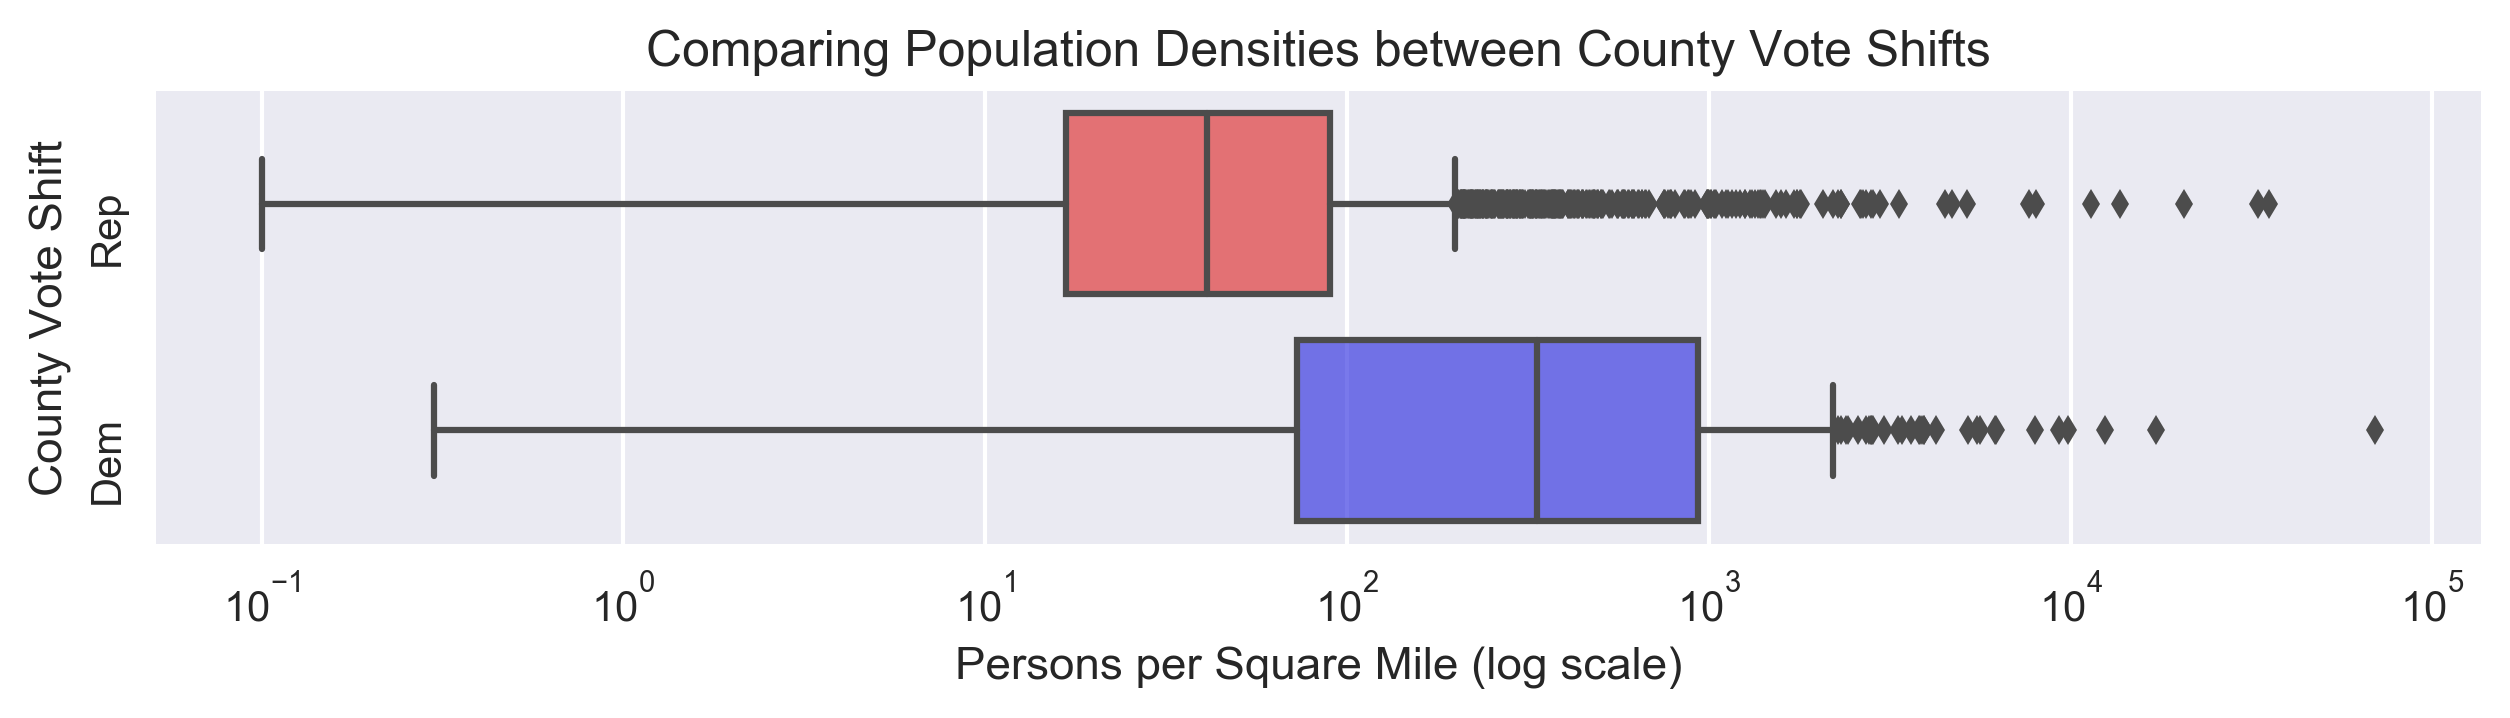

In [32]:
#Plot party shifts vs. population density
fig = plt.figure(figsize=(10,2),dpi=300)
my_pal = {"Republican": "r", "Democratic": "b"}
ax = sns.boxplot(x='pop_density', y='Shift', data=new_shifts, linewidth=1.5, palette=my_pal)
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .6))
ax.set_xscale('log')
ax.set_xlabel('Persons per Square Mile (log scale)')
ax.set_ylabel('County Vote Shift')
ax.set_yticklabels(labels=['Rep','Dem'],rotation=90)
ax.set_title('Comparing Population Densities between County Vote Shifts', fontsize=12)

Here we see another view of how county population density factored into vote shifts. We can again conclude that densely populated counties largely shifted to the left and vice versa.

## Conclusion

In this project, we used county vote shift and population density data to investigate the rural-urban divide in the 2016 election. We discovered that:
* Rural counties in the Midwest and northern New England shifted the most to the right, with most Obama-Trump counties coming from these regions. 
* Counties in metropolitan areas across the US swung the most to the left, along with most of California. 
* Population density largely determined whether a county would shift to the left or right in 2016, with less desely populated counties shifting to the right and more densely populated ones shifting to the left. 

We can conclude that the rural-urban divide grew much wider in 2016.

### Possible Further Steps
* Analyze demographic data to see if the rural counties that shifted to the left in 2016 are largely Hispanic.
* Analyze income data to see if income also played a large role in determining vote shifts.